<img src="https://s3.amazonaws.com/weclouddata/images/logos/wcd_logo_new_2.png" width="10%">
<h1><center>Computer Vision Project Template (Segmentation)</center></h1>

---

For this notebook, we will be using the Project Template.

The goal of the template is to make the Capstone Project implementation easy for the user.

# ML Project

There are 5 core components of a ML Project:
- Problem Statement
- Dataset
- DL Model
- Model Training
- Model Evaluation

The Template provides wrappers (Data and Model classes) and an API (ModelEngine) that works hand-in-hand with a Configuration. Together, they form a complete Training API.


Download and install the template

In [1]:
# !git clone https://github.com/jjaskirat/wcd_project_template.git
# %cd wcd_project_template
# ! python setup.py install
# %cd ..

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [3]:
import time
import os
import copy
from typing import Optional

import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import random
import segmentation_models_pytorch as smp
from sklearn.model_selection import train_test_split
import timm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import pandas as pd
import torchvision
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

/opt/conda/lib/python3.11/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 2.0.5 (you have 1.4.21). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## Problem Statement

---

Visual scene understanding of drone images has sparked great interest in the computer vision community, as it presents new challenges and potential for high-resolution drone image processing and complicated drone vision tasks like depth estimation[24, 23, 25], 3D reconstruction[12, 10], obstacle avoidance[42] and adaptive path planning[38, 32]. We propose Varied Drone Dataset(VDD), a varied and large dataset of 400 high-resolution images to facilitate future research in semantic segmentation of drone images, and we believe that VDD will pave the way for new approaches in the field of aerial image processing.

## Dataset

---

The Semantic Drone Dataset focuses on semantic understanding of urban scenes for increasing the safety of autonomous drone flight and landing procedures. The imagery depicts  more than 20 houses from nadir (bird's eye) view acquired at an altitude of 5 to 30 meters above ground. A high resolution camera was used to acquire images at a size of 6000x4000px (24Mpx). The training set contains 400 publicly available images and the test set is made up of 200 private images.
Person Detection
For the task of person detection the dataset contains bounding box annotations of the training and test set.
Semantic Segmentation
We prepared pixel-accurate annotation for the same training and test set. The complexity of the dataset is limited to 20 classes as listed in the following table.   Table 1: Semanic classes of the Drone Dataset

- tree
- gras
- other vegetation
- dirt
- gravel
- rocks
- water
- paved area
- pool
- person
- dog
- car
- bicycle
- roof
- wall
- fence
- fence-pole
- window
- door
- obstacle

Additional Data Available

- High resolution images at 1Hz
- Fish-eye stereo images at 5Hz with synchronized IMU measurements
- Thermal images at 1Hz
- Ground control points
- 3D ground truth of 3 houses acquired by a total station

In [4]:
import kagglehub

# Download latest version
ROOT_DIR = kagglehub.dataset_download("bulentsiyah/semantic-drone-dataset")

print("Path to dataset files:", ROOT_DIR)
print("Contents of Data Dir: ", os.listdir(ROOT_DIR))

Path to dataset files: /root/.cache/kagglehub/datasets/bulentsiyah/semantic-drone-dataset/versions/6
Contents of Data Dir:  ['class_dict_seg.csv', 'dataset', 'RGB_color_image_masks']


In [5]:
# Set Global Variable of num classes
NUM_CLASSES = 23 

In [6]:
# Show the img_dir

img_dir = f'dataset/semantic_drone_dataset/original_images'
print("Contents of Img Dir: ", os.listdir(f'{ROOT_DIR}/{img_dir}')[:5])

mask_dir = f'dataset/semantic_drone_dataset/label_images_semantic'
print("Contents of Mask Dir: ", os.listdir(f'{ROOT_DIR}/{mask_dir}')[:5])

Contents of Img Dir:  ['355.jpg', '002.jpg', '251.jpg', '458.jpg', '565.jpg']
Contents of Mask Dir:  ['569.png', '338.png', '535.png', '598.png', '181.png']


### Creation of DataFrame for dataset

The DataFrame will contain relative paths of the images and the labels of the dataset

It will be of the form:

image: [...]

mask: [...]

In [7]:
def create_df():
    img_path = []
    mask_path = []
    # Loop through all images
    for dirname, _, filenames in os.walk(os.path.join(ROOT_DIR, img_dir)):
        for filename in filenames:
            # Append image path and mask path to their lists
            img_path.append(os.path.join(img_dir, filename))
            mask_path.append(os.path.join(mask_dir, f'{filename[:-3]}png'))
    # Create df
    df = pd.DataFrame({
            'image': img_path,
            'mask': mask_path,
    })
    return df

df = create_df()
print('Total Images: ', len(df))

Total Images:  400


In [8]:
df

image  \
0    dataset/semantic_drone_dataset/original_images...   
1    dataset/semantic_drone_dataset/original_images...   
2    dataset/semantic_drone_dataset/original_images...   
3    dataset/semantic_drone_dataset/original_images...   
4    dataset/semantic_drone_dataset/original_images...   
..                                                 ...   
395  dataset/semantic_drone_dataset/original_images...   
396  dataset/semantic_drone_dataset/original_images...   
397  dataset/semantic_drone_dataset/original_images...   
398  dataset/semantic_drone_dataset/original_images...   
399  dataset/semantic_drone_dataset/original_images...   

                                                  mask  
0    dataset/semantic_drone_dataset/label_images_se...  
1    dataset/semantic_drone_dataset/label_images_se...  
2    dataset/semantic_drone_dataset/label_images_se...  
3    dataset/semantic_drone_dataset/label_images_se...  
4    dataset/semantic_drone_dataset/label_images_se...  
..                                                 ...  
395  dataset/semantic_drone_dataset/label_images_se...  
396  dataset/semantic_drone_dataset/label_images_se...  
397  dataset/semantic_drone_dataset/label_images_se...  
398  dataset/semantic_drone_dataset/label_images_se...  
399  dataset/semantic_drone_dataset/label_images_se...  

[400 rows x 2 columns]

# Data Exploration and Visualization

In [9]:
def plot_drone_data(df, num_images):
    for i in range(num_images):
        # Get random index
        random_idx = np.random.randint(0, len(df))
        # Get image
        image = cv2.imread(f"{ROOT_DIR}/{df.iloc[random_idx]['image']}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        # Get mask
        mask = df.iloc[random_idx]['mask']
        mask = cv2.imread(f"{ROOT_DIR}/{df.iloc[random_idx]['mask']}")
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
        
        # Plot both the images in 2 columns
        fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,36))
        ax1.imshow(image)
        ax2.imshow(mask)
        ax1.set_title('Image')
        ax2.set_title('Mask')
        plt.show()

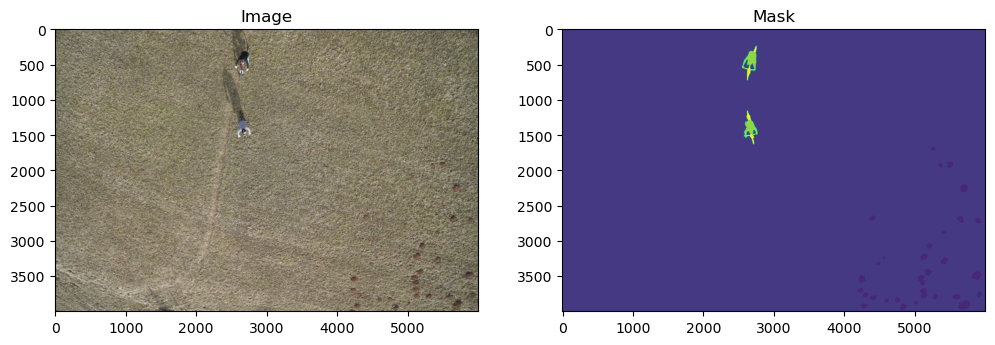

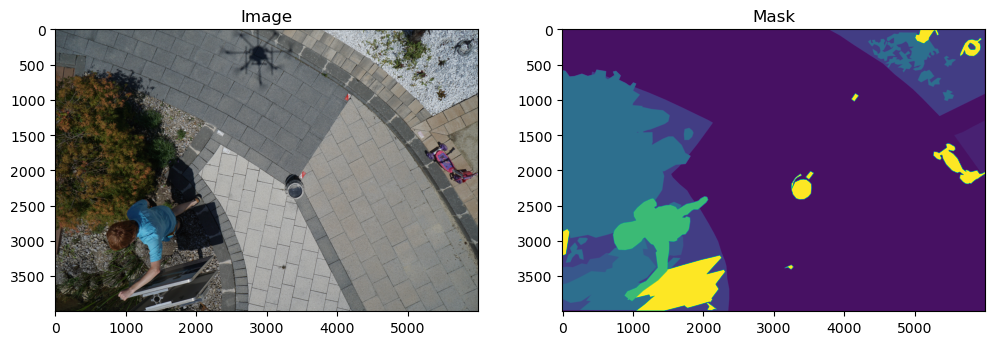

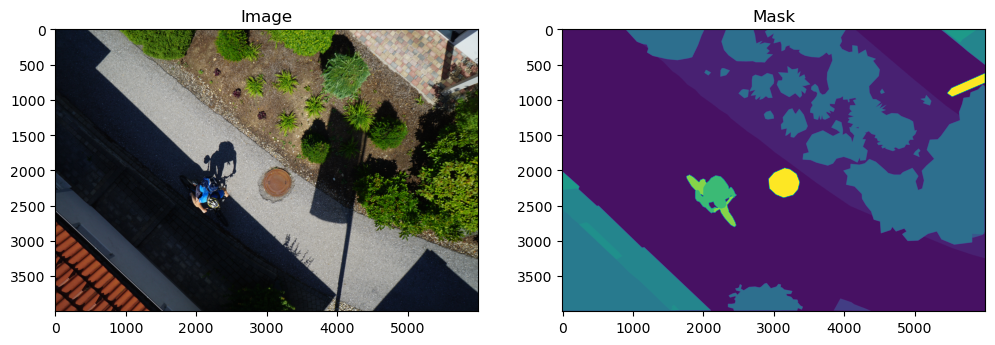

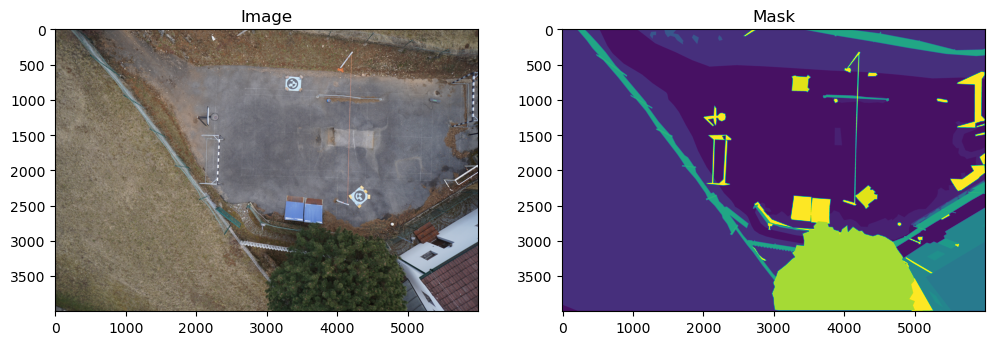

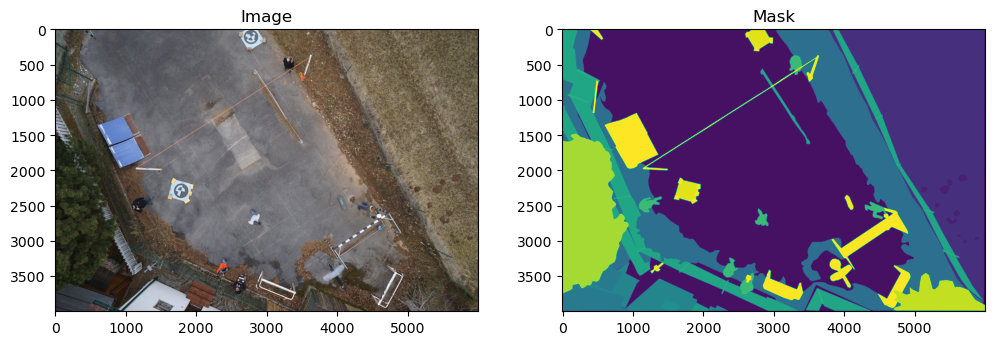

In [10]:
plot_drone_data(df, 5)

## Dataset Creation

The template provides a wrapper on top of a torch Dataset.

The user is responsible to create their own dataset and load it in PyTorch.

The `Data` class inherits from the `torch.utils.data.Dataset` class. It implements the `__len__` and the `__getitem__` functions. The user must implement the `get_input`, `get_label` and `apply_transform` functions, which define how the input and the labels can be obtained from a `pd.core.frame.DataFrame`

In [11]:
# Import Data from the template
from wcd_project_template.data import Data

In [12]:
class DataSegmentation(Data):
    def __init__(
            self,
            df,
            config_data: dict,
            transform: Optional[A.Compose] = None
        ):
        super().__init__(df, config_data, transform)

    def get_input(self, row):
        """defines how you get the input image from the df

        Returns:
            np.ndarray: the image
        """
        input_path = os.path.join(self.root_dir, row['image'])
        input = cv2.imread(input_path)
        input = cv2.cvtColor(input, cv2.COLOR_BGR2RGB)
        return input

    def get_label(self, row):
        """defines how you get the label
        (classification or mask or objects) from the df

        Returns:
            Union[np.ndarray, int]: the label
        """
        label_path = os.path.join(self.root_dir, row['mask'])
        label = cv2.imread(label_path)
        label = cv2.cvtColor(label, cv2.COLOR_BGR2GRAY)
        return label

    def apply_transform(self, input, label):
        """applies the transformation on both the image and the label respectively.
        For classification, we do not need to apply any transformation on the label.

        Returns:
            Tuple[np.ndarray, int, torch.Tensor]: the transformed images and labels
        """
        transformed = self.transform(image=input, mask=label)
        input = transformed['image']
        label = transformed['mask']
        label = torch.as_tensor(label, dtype=torch.long)
        # label = torch.nn.functional.one_hot(label, 23)
        return input, label

### How to create your own Dataset

You need to define the `__init__` and `__getitem__` methods according to `torch.utils.data.Dataset`. Then an additional `get_dataloader` method needs to be defined which gets any dataloader

In [13]:
# from torch.utils.data import Dataset
# from wcd_project_template.data import Data, DataLoader

# class CustomDataset(Dataset, Data):
#     def __init__(self, config, **kwargs):
#         """__init__ method according to torch.utils.data.Dataset

#         Args:
#             config (dict): dict containing important config variables
#         """
#         self.config = config
#         ...
    
#     def __getitem__(self, idx):
#         """__getitem__ method according to torch.utils.data.Dataset

#         Args:
#             idx (int):
#         """
#         ...

#     def __len__(self):
#         ...
        
#     def get_dataloader(self):
#         """returns the dataloader on self

#         Returns:
#             Iterable: The dataloader
#         """
#         return DataLoader(self, **self.config['dataloader'])

### Define the Transforms

Please note, we also create an inverse_transformation for plotting test data

##### We will use the Albumentations Library for transforms
https://albumentations.ai/docs/

##### Selected Transforms:
- Resize
- Horizontal Flip
- GridDistortion
- RandomBrightnessContrast
- GaussNoise
- Normalize according to Imagenet Mean and Std
- Convert to Tensor

In [14]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

transforms_train = A.Compose(
    [
        A.Resize(768, 768),
        A.HorizontalFlip(p=0.5),
        A.GridDistortion(p=0.2),
        A.RandomBrightnessContrast((0,0.5),(0,0.5)),
        A.GaussNoise(p=0.8),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

# Note: In validation transforms, we do not add the Horizontal Flip transform
transforms_valid = A.Compose(
    [
        A.Resize(768, 768),
        A.Normalize(
            mean=mean.tolist(),
            std=std.tolist(),
            max_pixel_value=255,
        ),
        ToTensorV2(),
    ]
)

# Validation Inverse Transforms
# This essentially does an unnormalize on the image.
# We can use this transformation to get the original
# image back after applying the transforms to it
transforms_valid_inverse = A.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

The `Data` configuration consists of the `root_dir` to specify where the images are present. Then it consists of a `dataloader` where you can specify the kwargs for `torch.utils.data.DataLoader`

In [15]:
# Training Data config
config_dataset_train = {
    'root_dir': ROOT_DIR,
    'dataloader': {
        'batch_size': 8,
        'shuffle': True,
        'num_workers': 4
    },
}

# Validation data config
config_dataset_valid = {
    'root_dir': ROOT_DIR,
    'dataloader': {
        'batch_size': 8,
        'shuffle': False,
        'num_workers': 4
    },
}

### Convert the dataset into train, valid and test set

10% test set | 9% valid set | 91% train set

We use train_test_split from sklearn to connvert the df into train, valid and test sets

In [16]:
# We use train_test_split from sklearn to connvert the df into train, valid and test sets

df_trainval, df_test = train_test_split(df, test_size=0.1, random_state=19)
df_train, df_valid = train_test_split(df_trainval, test_size=0.1, random_state=19)

print('Train Size   : ', len(df_train))
print('Val Size     : ', len(df_valid))
print('Test Size    : ', len(df_test))

Train Size   :  324
Val Size     :  36
Test Size    :  40


In [17]:
# Now we need to create the 

# Training Data
data_train = DataSegmentation(
    df_train,
    config_dataset_train,
    transform=transforms_train
)
# Validation Data
data_valid = DataSegmentation(
    df_valid,
    config_dataset_valid,
    transform=transforms_valid
)
# Testing Data
data_test = DataSegmentation(
    df_test,
    config_dataset_valid,
    transform=transforms_valid
)

Checking what the data looks like

In [18]:
data_train[0]

(tensor([[[-1.3644, -1.3302, -1.2617,  ..., -1.7069, -1.3815, -1.6555],
          [-1.1760, -1.2959, -1.2959,  ..., -1.0048, -1.1932, -1.0904],
          [-1.2959, -1.2959, -1.3815,  ..., -0.0116, -0.2856,  0.0398],
          ...,
          [-0.3369,  0.3309,  0.4166,  ..., -1.6898, -1.8439, -1.7754],
          [ 0.2453,  0.3823,  0.4851,  ..., -1.6898, -1.7754, -1.7240],
          [-0.2684,  0.2624,  0.5193,  ..., -1.7240, -1.8610, -1.6213]],
 
         [[-0.8102, -0.9678, -0.9853,  ..., -1.3004, -1.0728, -1.2304],
          [-0.8627, -0.9853, -1.1954,  ..., -0.7752, -1.0903, -0.8978],
          [-0.9678, -0.9853, -0.9328,  ...,  0.3102,  0.1001,  0.2752],
          ...,
          [ 0.2577,  0.8004,  0.8704,  ..., -1.8081, -1.8256, -1.8957],
          [ 0.5028,  0.6604,  0.9930,  ..., -1.6506, -1.6155, -1.6681],
          [ 0.3627,  0.9405,  0.9755,  ..., -1.6155, -1.8256, -1.6506]],
 
         [[-0.3578, -0.4101, -0.3753,  ..., -1.6650, -1.5430, -1.6302],
          [-0.5321, -0.4624,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.172549..1.0895599].


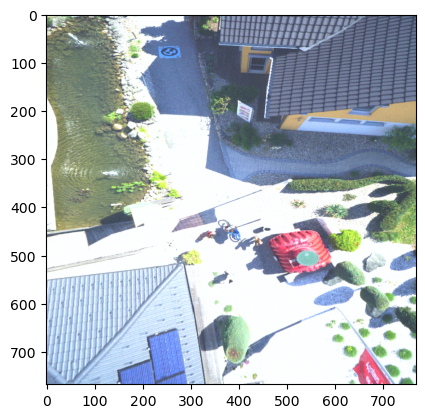

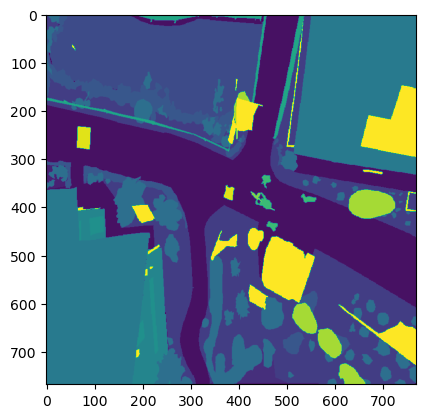

In [19]:
img, label = data_train[0]
img = transforms_valid_inverse(image=img.numpy()*255)['image']
plt.imshow(img.transpose((2,1,0)))
plt.show()
plt.imshow(label)
plt.show()

## DL Model

---

he template provides a wrapper on top of a torch model. The template provides the usage of 3 different libraries:
- `timm`, `segmentation-models-pytorch` and `detectron2`

For Segmentation Purposes:
- segmentation-models-pytorch
    - [Github and Documentation](https://github.com/qubvel-org/segmentation_models.pytorch)
    - comprehensive list of Segmentation models,
    - Provides multiple models Ex: DeepLabV3, Unet, FPN, etc
    - It uses the `timm` models as encoder to the segmenation model.

In [20]:
# Import Model from the template
from wcd_project_template.model import Model

The `Model` configuration consists of the `model_hyperparameters` to specify the parameters of the model. Then it consists of a `weights_path` where you can load pretrained model_weights from. Finally a `freeze_layer` which specifies the layers you want to freeze (perform no backpropagation on)

Check Out: [Segmentation Models](https://smp.readthedocs.io/en/latest/models.html)

In [21]:
# To create a wcd_project_template.model.Model,
# we need a configuration file and a model
# We define the configuration as seen below.
# model_hyperparameters is 
config_model = {
    'model_hyperparameters':{
        'encoder_name': 'resnet101',
        'encoder_depth': 5,
        'encoder_weights': 'imagenet',
        'classes': 23,
        'activation': None,
    },
    'weights_path': None,
    'freeze_layers': [],
}

# refer to https://smp.readthedocs.io/en/latest/models.html
# For all other segmentation models available

model_ = smp.DeepLabV3Plus(
    **config_model['model_hyperparameters']
)
model = Model(model_, config_model)

done loading model


In [22]:
model

Model(
  (model): DeepLabV3Plus(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU

### Things to note about the smp models:

- The model head always predicts an output of dimensions (batch_size, num_classes, img_h, img_w)

### How to create your own Model

In [23]:
# import torch.nn as nn
# from wcd_project_template.model import Model

# class CustomModel(nn.Module):
#     def __init__(self, config):
#         self.config = config
#         ...
        
#     def forward(self, x):
#         ...
        
# config={
#     'model_hyperparameters': {},
#     ...
# }
# model_ = CustomModel(config['model_hyperparameters'])
# model = Model(model_, config)

## Model Training

---

The template provides you with a `ModelEngine` class. This class is responsible for supervised model training and evaluation. The code for training or evaluating the model is generally the same for every model. The components that change are the `Loss`, `Metric` and `Optimizer`.
- Loss
    - The loss function can be imported from any library
    - It can also be a custom loss function as seen [here](https://discuss.pytorch.org/t/custom-loss-functions/29387/2)
- Metric
    - Any metric can be used from the library `torchmetrics`.
    - Options for a custom metric are also provided [here](https://lightning.ai/docs/torchmetrics/stable/pages/implement.html)
- Optimizer
    - The optimizer must be from the `torch.optim` module.
    - Any optimizer can be selected
    - Options for a custom optimizer are also provided on the docs

### For Segmentation

- Loss
    - We can use the Loss provided in the smp library

- Metric
    - Since we are solving a multiclass problem, the metric input should be of size (batch_size, 1, img_h, img_w)
    - We need to apply Argmax (which is selecting the maximum valued class from the softmax output) to the output of the model here
    - We use 2 different metrics, IOU and Dice Score

- Optimizer
    - We use the standard Adam Optimizer

In [24]:
# Import ModelEngine from the template
from wcd_project_template.model_engine import ModelEngine

In [25]:
engine = ModelEngine('cuda')

The Model Engine config consists of the training parameters like `num_epochs`, then it contains sections where you can modify the `criterion`, `metric` and `optimizer`

The `name` parameter is a string corresponding to the import string of the Class. Except for the Optimizer, where it is the optimizer name

The `config` is the kwargs for the Class imported from the `name` parameter



In [26]:
# Loss  ------------------------
# Defined under config

In [27]:
from torchmetrics import MetricCollection
from torchmetrics.segmentation import MeanIoU, GeneralizedDiceScore

class MeanIoUWithArgMax(MeanIoU):
    # https://lightning.ai/docs/torchmetrics/stable/segmentation/mean_iou.html
    def __call__(self, preds, target):
        preds = torch.argmax(preds, dim=1)
        return super().__call__(preds, target)
    
class GeneralizedDiceScoreWithArgMax(GeneralizedDiceScore):
    # https://lightning.ai/docs/torchmetrics/stable/segmentation/generalized_dice.html
    def __call__(self, preds, target):
        preds = torch.argmax(preds, dim=1)
        return super().__call__(preds, target)

In [28]:
# Optimizer ---------------------
# Defined under config

In [29]:
config_training = {
    'num_epochs': 100,
    'optimizer': {
        # Corresponds to the Optimizer present in torch.optim
        # https://pytorch.org/docs/stable/optim.html
        'name': 'Adam',
        # Configuration of the optimizer
        'config': {
            'lr': 0.001,
            'weight_decay': 1e-5,
        },
    },
    'criterion': {
        # Dice Loss from smp
        # https://smp.readthedocs.io/en/latest/losses.html#diceloss
        'name': 'segmentation_models_pytorch.losses.DiceLoss',
        # Criterion configuration
        'config': {
            'mode': 'multiclass',
            'classes': NUM_CLASSES,
            'from_logits': True,
        },
    },
    'metric':{
        # Collection of Metrics
        # https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metriccollection
        'name': MetricCollection,
        'config':{
            'metrics': [
                MeanIoUWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                ),
                GeneralizedDiceScoreWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                )
            ]
        }
    }
}

config_evaluation = {
    'criterion': {
        # Dice Loss from smp
        # https://smp.readthedocs.io/en/latest/losses.html#diceloss
        'name': 'segmentation_models_pytorch.losses.DiceLoss',
        # Criterion configuration
        'config': {
            'mode': 'multiclass',
            'classes': NUM_CLASSES,
            'from_logits': True,
        },
    },
    'metric':{
        # Collection of Metrics
        # https://lightning.ai/docs/torchmetrics/stable/pages/overview.html#metriccollection
        'name': MetricCollection,
        'config':{
            'metrics': [
                MeanIoUWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                ),
                GeneralizedDiceScoreWithArgMax(
                    num_classes=NUM_CLASSES,
                    input_format='index',
                    per_class=False,
                    include_background=True,
                )
            ]
        }
    }
}

Use the engine with the configuration to train the model

In [30]:
trained_model, training_meta_data = engine.train(
    model = model,
    data_train = data_train,
    data_valid = data_valid,
    config_training = config_training,
    config_evaluation = config_evaluation
)

Total Training Samples:  324


  0%|          | 0/100 [00:00<?, ?it/s]

Epoch-1: ===========================================
Training: ===========            
Loss: 0.779294028514769,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.07003234), 'GeneralizedDiceScoreWithArgMax': np.float32(0.0430147)},            
Time: 22.712375144998077 seconds
Validation: =========            
Loss = 0.8816010355949402,            
Metrics: {'MeanIoUWithArgMax': array(0.0692098, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.04211754, dtype=float32)},            
Time: 3.0737874360056594 seconds

Epoch-2: ===========================================
Training: ===========            
Loss: 0.6919280654046593,            
Metrics: {'MeanIoUWithArgMax': np.float32(0.11397886), 'GeneralizedDiceScoreWithArgMax': np.float32(0.08833875)},            
Time: 22.70464948699373 seconds
Validation: =========            
Loss = 0.7531513571739197,            
Metrics: {'MeanIoUWithArgMax': array(0.11187045, dtype=float32), 'GeneralizedDiceScoreWithArgMax': array(0.049

### Training Plots

#### Loss plot

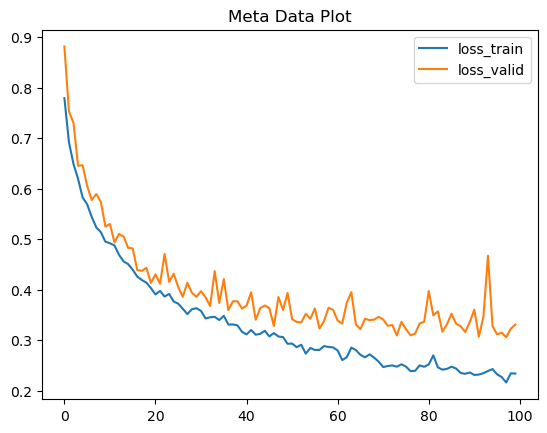

In [31]:
engine.plot(training_meta_data, ['loss_train', 'loss_valid'])

#### Metric Plot

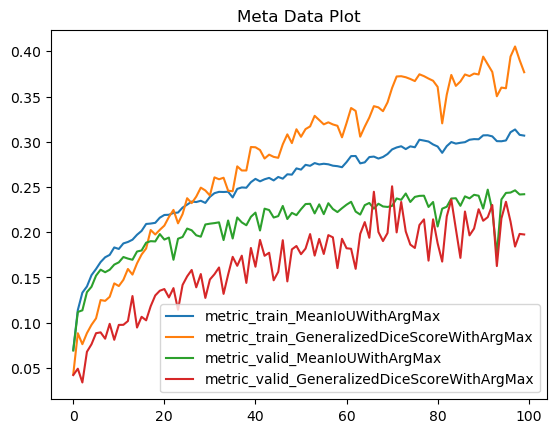

In [32]:
engine.plot(training_meta_data, ['metric_train', 'metric_valid'])

#### Save the trained model

In [33]:
# torch.save(trained_model, 'segmentation_model.pth')

#### Load a previously trained model

In [34]:
trained_model = torch.load('segmentation_model.pth')

/tmp/ipykernel_105425/2684734109.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  trained_model = torch.load('segmentation_model.pth')


## Model Evaluation

---

The model can be evaluated similar to the training method. By specifying the trained_model, data_test and the config_evaluation

In [35]:
engine.evaluate(
    model = trained_model,
    data_valid = data_test,
    config_evaluation = config_evaluation
)

(array(0.31631613, dtype=float32),
 {'MeanIoUWithArgMax': array(0.24766624, dtype=float32),
  'GeneralizedDiceScoreWithArgMax': array(0.1826711, dtype=float32)})

We can see that the model has an IoU of 0.247 on the Test Set

## Visualize The Predictions

In [36]:
# Make predictions on the test set
outputs, labels, inputs = engine._make_predictions(trained_model, data_test.get_dataloader(), return_input=True)

In [37]:
# Helper Functions for visualization

def visualize_predictions(inputs, outputs, labels, num_images=10):
    # Inverse transform the images
    inputs = transforms_valid_inverse(image=inputs.cpu().numpy()*255)['image']
    outputs = outputs.cpu().numpy()
    labels = labels.cpu().numpy()
    for i in range(num_images):
        # Get random idx
        random_idx = np.random.randint(0, len(inputs))
        input_idx = inputs[random_idx]
        output_idx = outputs[random_idx]
        label_idx = labels[random_idx]
        
        # Plot the images and the ground truth
        fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(12, 36))
        ax1.imshow((input_idx.transpose(1,2,0)*255).astype(np.uint8))
        ax2.imshow(np.argmax(output_idx, axis=0))
        ax3.imshow(label_idx)
        
        ax1.set_title('Image')
        ax2.set_title('Prediction')
        ax3.set_title('Ground Truth')
        plt.show()

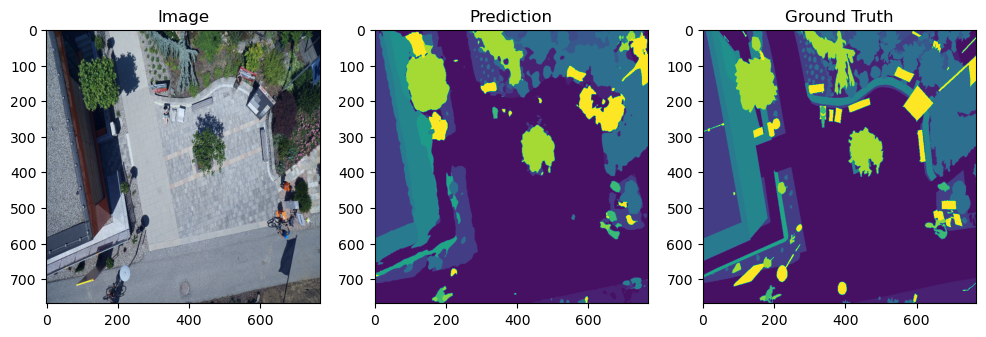

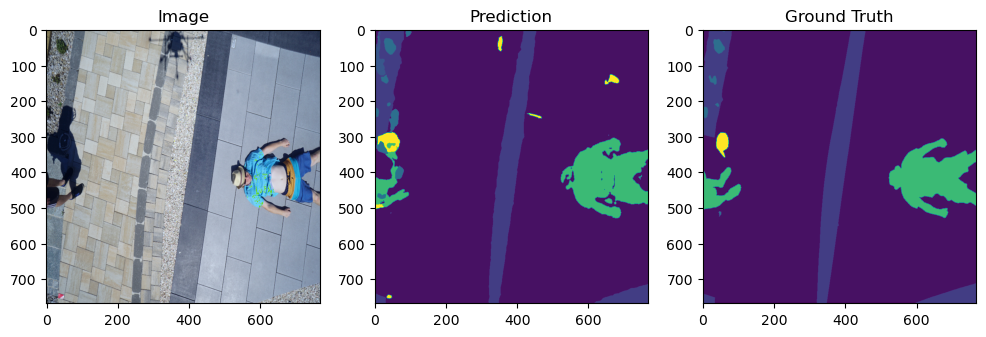

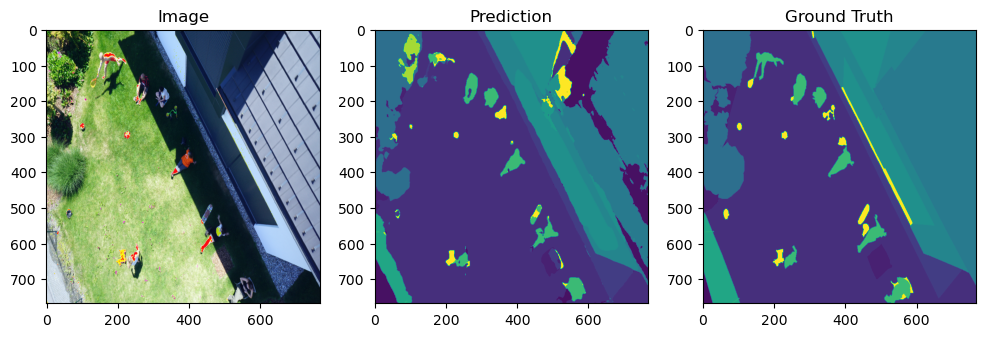

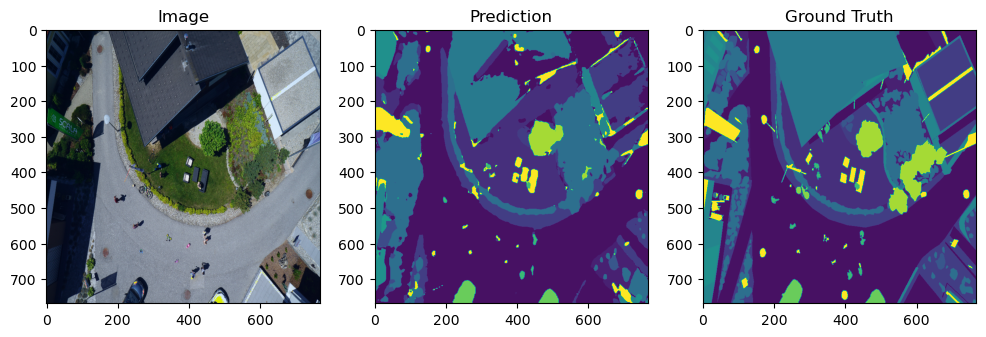

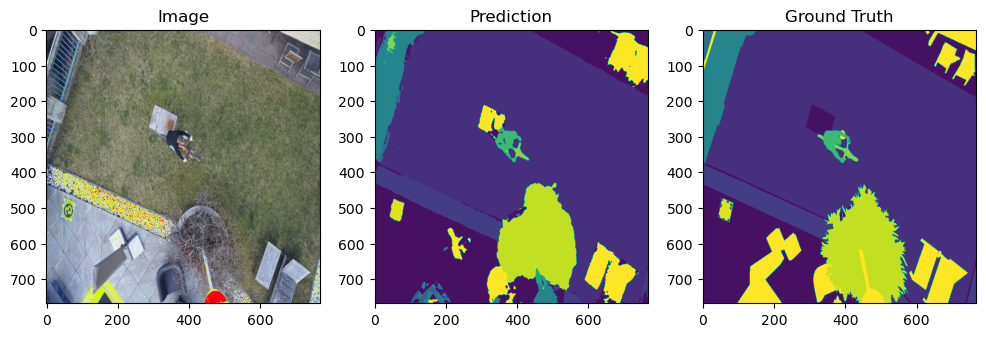

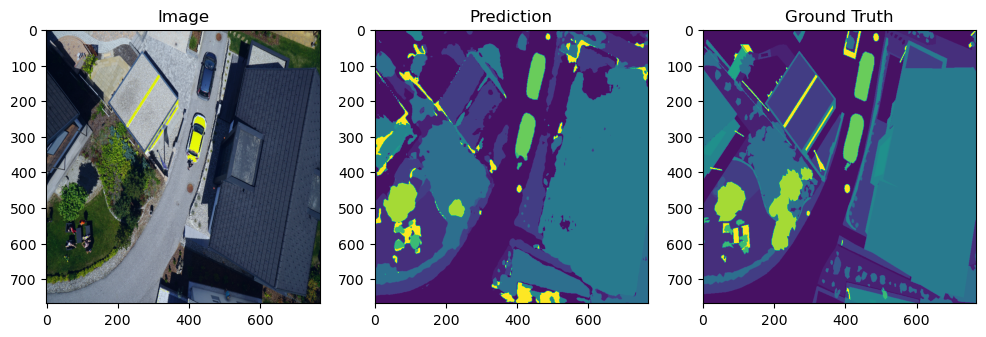

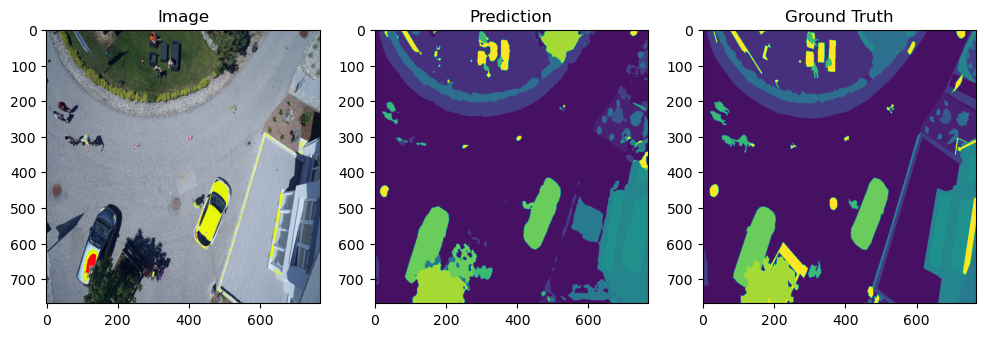

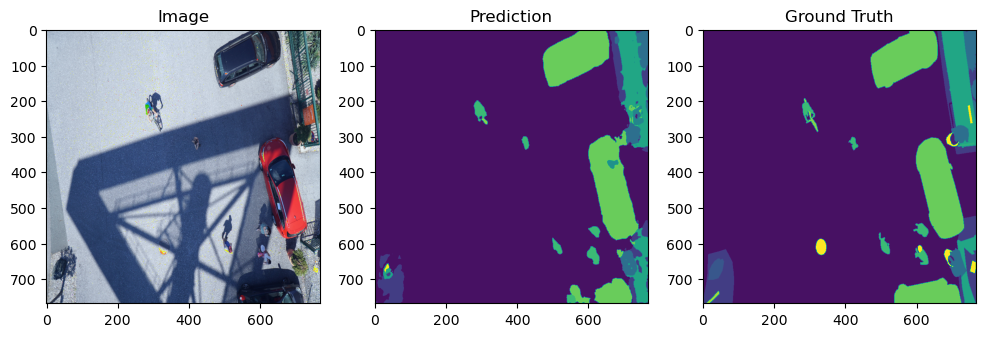

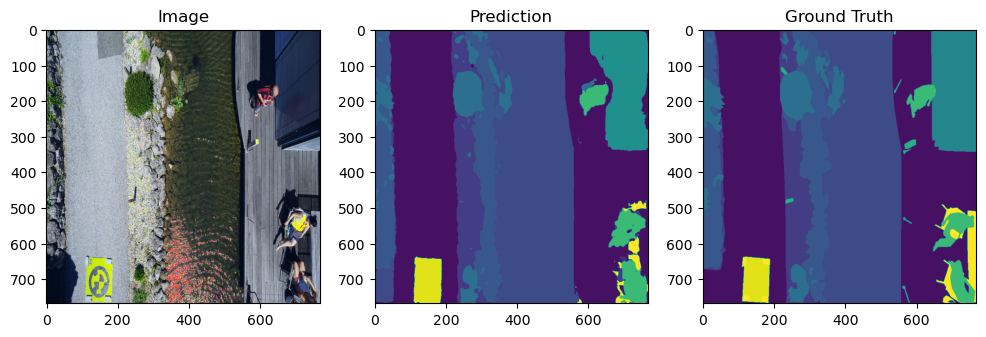

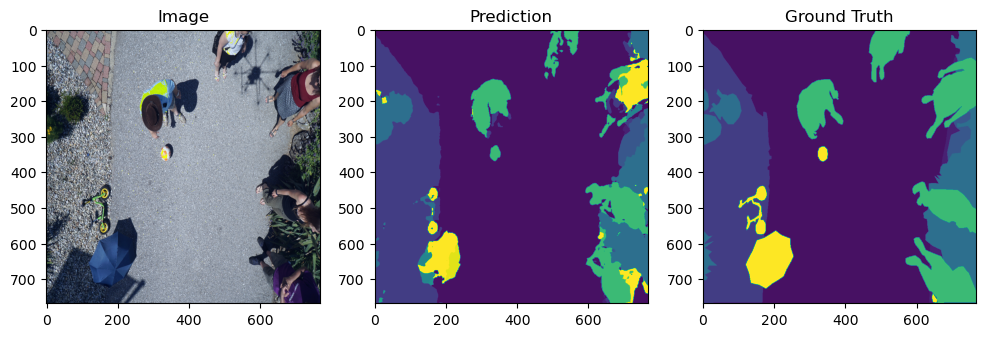

In [38]:
visualize_predictions(
    inputs,
    outputs,
    labels
)